In [1]:
from data import load_mri_dataframe, get_dataloaders

In [2]:
df = load_mri_dataframe()

train_loader, val_loader = get_dataloaders(df, omit_empty_masks=True)

[Data] Train images: 1106 ; Val images: 267


In [3]:
import torch
import torch.nn as nn

In [4]:
class BaselineUNet(nn.Module):
    def __init__(self):
        super().__init__()
        num_classes = 1
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)  # 128x128

        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)  # 64x64

        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())

        # Decoder
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # 64x64
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())

        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)  # 128x128
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU())

        # Final
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        return self.final(d1)


In [5]:
model = BaselineUNet()

device = torch.device('cuda')

Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 139/139 [00:03<00:00, 41.52it/s]


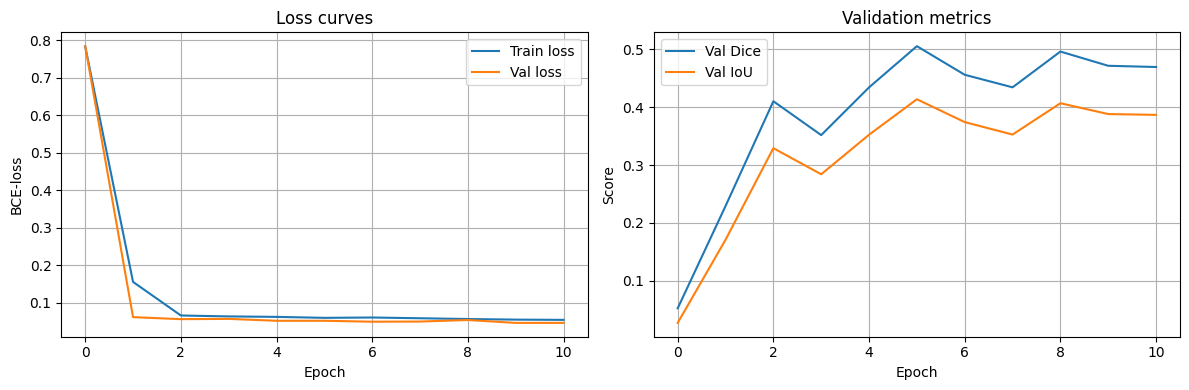

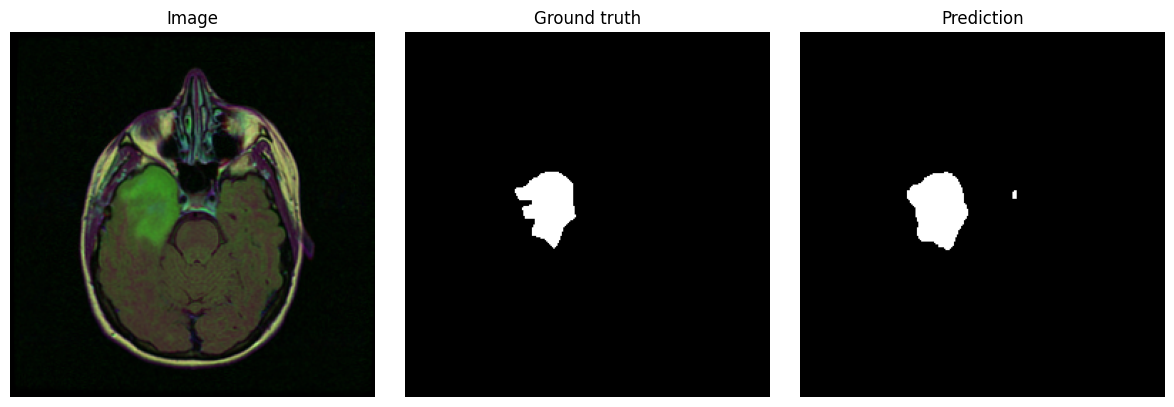

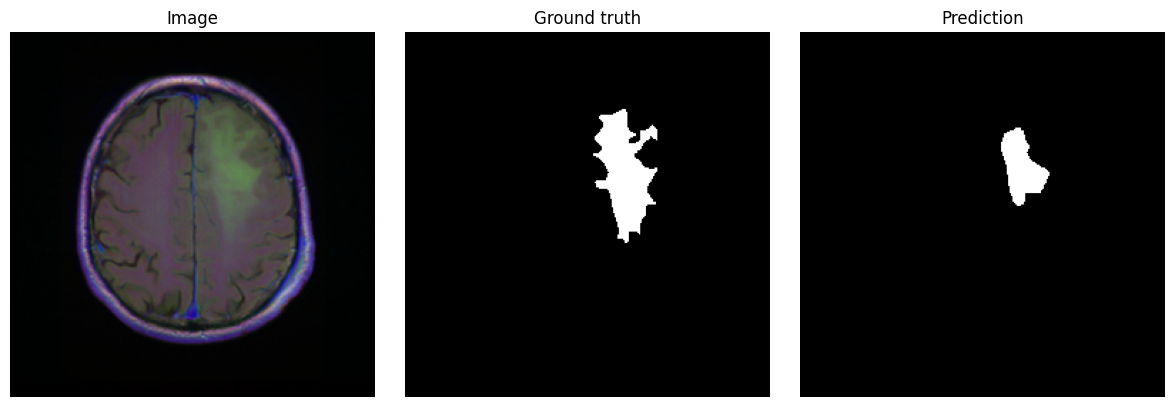

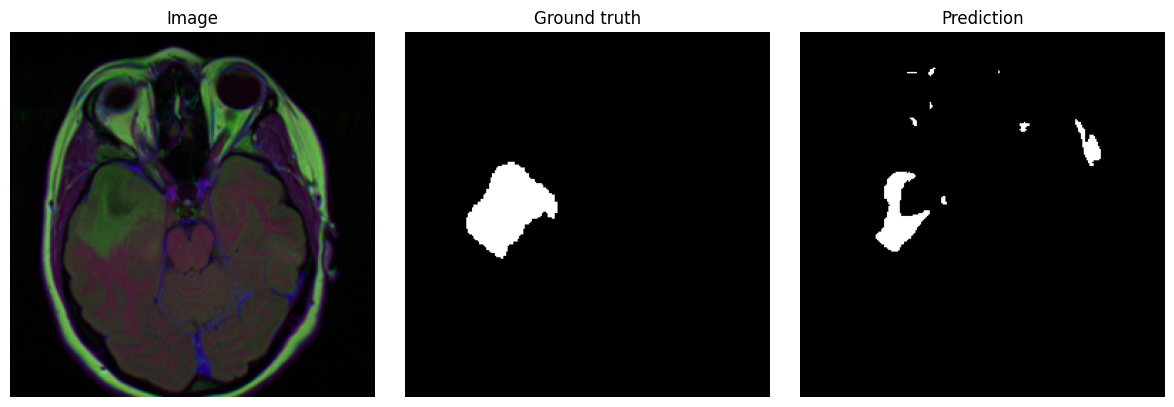

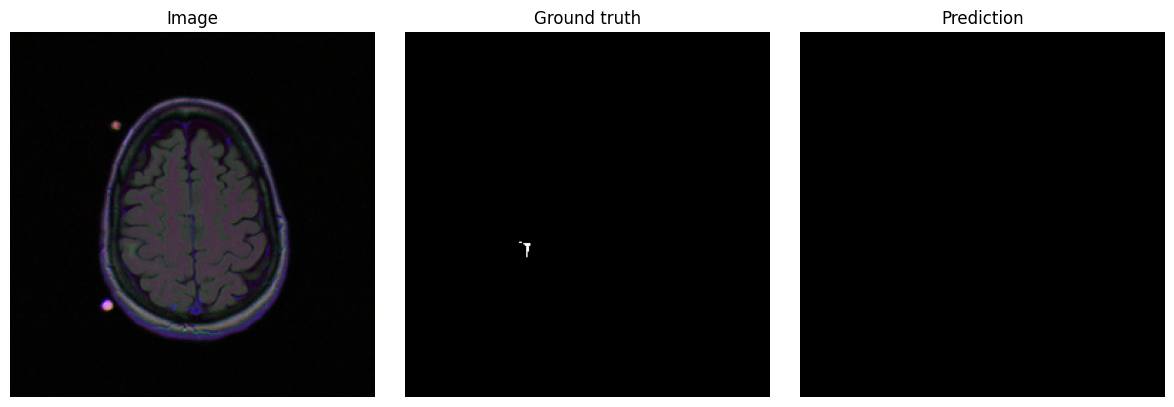

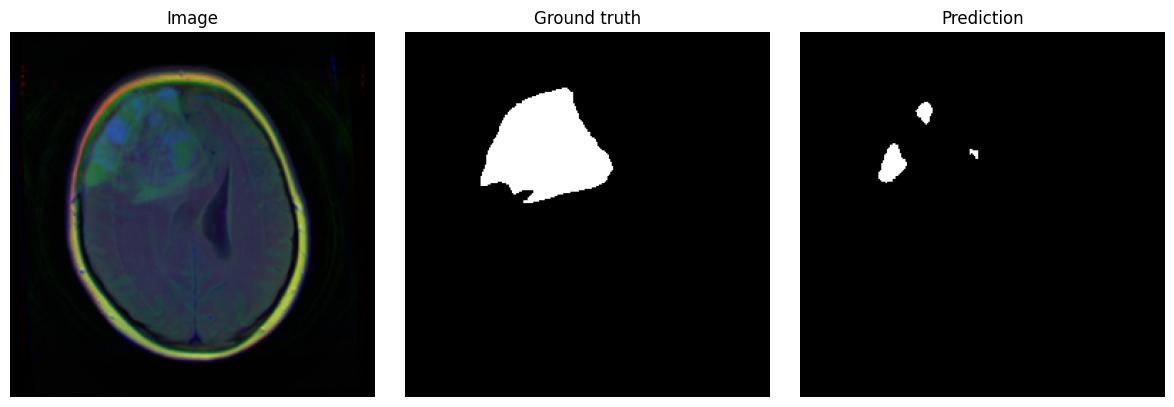

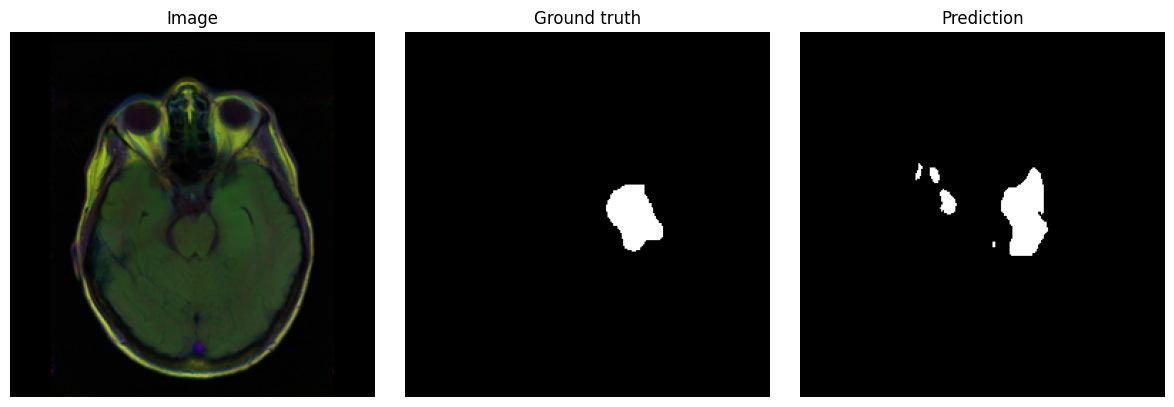

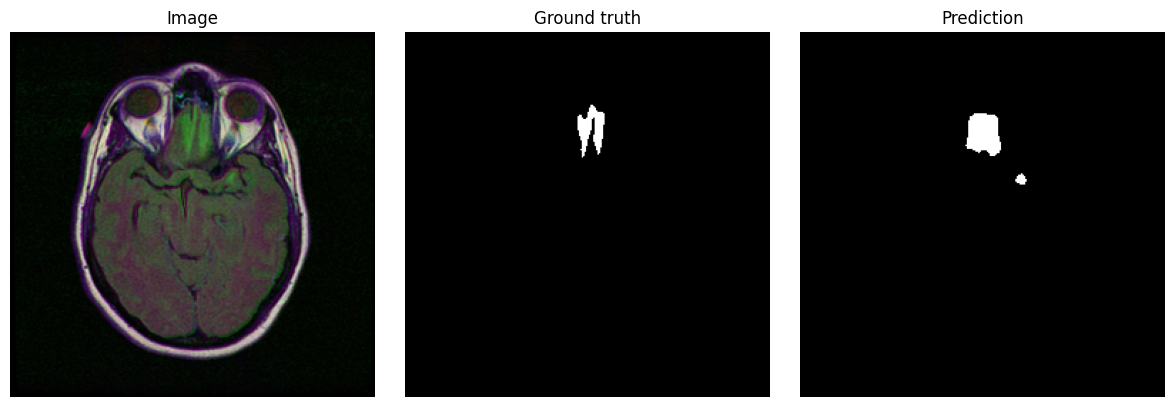

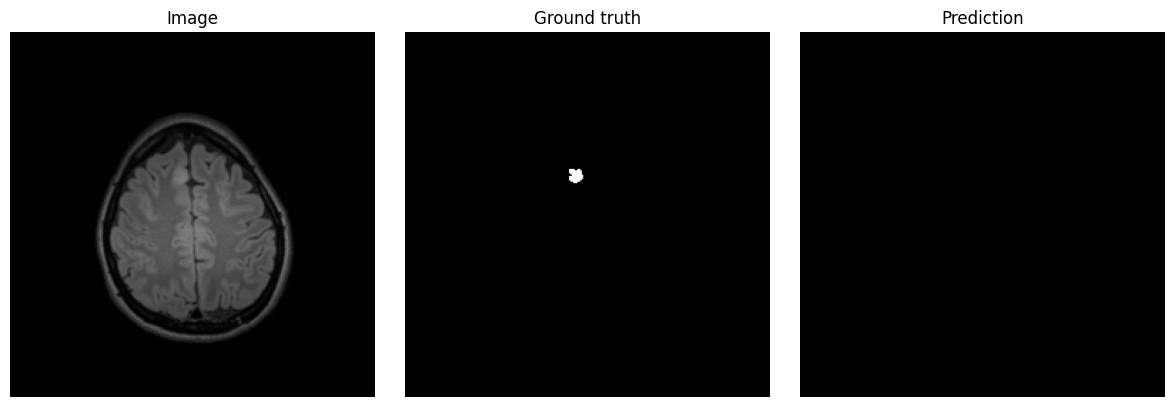

Final Val Dice: 0.4691
Final Val IoU : 0.3865


In [6]:
from train import train
from eval import evaluate

trained_model, results = train(model, train_loader, val_loader, device)

evaluate(results)